In [1]:
!pip install sklearn
!pip install keras
!pip install tensorflow

In [117]:
QUESTION_MAXLEN = 256
SUPPORT_MAXLEN = 512
ANSWER_MAXLEN = 8
FEATURE_LEN = 1
DATA_LENGTH = QUESTION_MAXLEN + SUPPORT_MAXLEN + ANSWER_MAXLEN*4 + FEATURE_LEN*4

PATH_TO_SCIQ_DATASET = 'data/'
TEST_FILENAME = 'test.json'
TRAIN_FILENAME = 'train.json'
VALIDATION_FILENAME = 'valid.json'

In [118]:
import json
import random
from sklearn.model_selection import cross_val_score

with open(PATH_TO_SCIQ_DATASET+TEST_FILENAME,'r') as json_file:
    test_data =  json.load(json_file)

with open(PATH_TO_SCIQ_DATASET+TRAIN_FILENAME,'r') as json_file:
    train_data =  json.load(json_file)

with open(PATH_TO_SCIQ_DATASET+VALIDATION_FILENAME,'r') as json_file:
    validation_data =  json.load(json_file)

    
print('test_data:',len(test_data))
print('train_data:',len(train_data))
print('validation_data:',len(validation_data))

test_data: 1000
train_data: 11679
validation_data: 1000


In [87]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [25]:
print(train_data[6])

{'question': 'What kind of a reaction occurs when a substance reacts quickly with oxygen?', 'distractor3': 'nitrogen reaction', 'distractor1': 'invention reaction', 'distractor2': 'Fluid Reaction', 'correct_answer': 'combustion reaction', 'support': 'A combustion reaction occurs when a substance reacts quickly with oxygen (O 2 ). For example, in the Figure below , charcoal is combining with oxygen. Combustion is commonly called burning, and the substance that burns is usually referred to as fuel. The products of a complete combustion reaction include carbon dioxide (CO 2 ) and water vapor (H 2 O). The reaction typically gives off heat and light as well. The general equation for a complete combustion reaction is:.'}


In [26]:
from __future__ import print_function

import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten, Dropout, LSTM
from keras.models import Model
from keras.initializers import Constant


BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, 'data/glove.6B')
TEXT_DATA_DIR = os.path.join(BASE_DIR, 'data')
MAX_SEQUENCE_LENGTH = 256
MAX_NUM_WORDS = 400000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2

# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt')) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [27]:
texts = []

aggregated_data = []

aggregated_data.extend(test_data)
aggregated_data.extend(train_data)
aggregated_data.extend(validation_data)

for data_item in aggregated_data:
    texts.append(data_item['question'])
    texts.append(data_item['support'])
    texts.append(data_item['distractor1'])
    texts.append(data_item['distractor2'])
    texts.append(data_item['distractor3'])
    texts.append(data_item['correct_answer'])
    
print (len(texts))

82074


In [88]:
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)

print('Preparing embedding matrix.')

word_index = tokenizer.word_index

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=DATA_LENGTH,
                            trainable=False)

print ('num_words',num_words)

Preparing embedding matrix.
num_words 28523


In [76]:
def get_question_form_data(dataset):        
    question_form_data = []
    correct_answers = []

    for data_item in dataset:
        form_data = {}
        
        question = data_item['question']
        support = data_item['support']

        local_answers = []
        local_answers.append(data_item['distractor1'])
        local_answers.append(data_item['distractor2'])
        local_answers.append(data_item['distractor3'])
        position = random.randrange(4)
        local_answers.insert(position,data_item['correct_answer'])
        
        answers.append(local_answers)   
            
        form_data['answers'] = local_answers
        form_data['question'] = question
        form_data['support'] = data_item['support']        
        
        question_form_data.append(form_data)
        correct_answers.append(position)

    return question_form_data, correct_answers


def pad_and_vectorize(text, tokenizer, padding):
    vectorized = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(vectorized, maxlen=padding)
    return padded

def extract_features(data_item):    
    features = []    
    question = data_item['question']
    support = data_item['support']
    answers = data_item['answers']       
    
    for option in answers:
        if support.lower().find(option.lower())>-1:
            features.append('1')
        else:
            features.append('0')
    return features


def get_vectorized_data_row(data_item, tokenizer):
    question = data_item['question']
    support = data_item['support']
    answers = data_item['answers']
    features = extract_features(data_item)

    question_vectorized = pad_and_vectorize ([question], tokenizer, QUESTION_MAXLEN)[0]
    support_vectorized = pad_and_vectorize ([support], tokenizer, SUPPORT_MAXLEN)[0]        
    answers_vectorized = pad_and_vectorize (answers, tokenizer, ANSWER_MAXLEN)  
    features_vectorized = pad_and_vectorize (features, tokenizer, FEATURE_LEN)      
        
    row = []
    row.extend(question_vectorized)
    row.extend(support_vectorized)    
    for answer in answers_vectorized:
        row.extend(answer)        
    for feature in features_vectorized:
        row.extend(feature)        

    return np.array(row)


def get_padded_vectors_combined(form_data, tokenizer):
    vectorized_data = []
    for data_item in form_data:
        data_row = get_vectorized_data_row(data_item, tokenizer)
        vectorized_data.append (data_row)
    return vectorized_data

In [83]:
validation_form_data, validation_correct = get_question_form_data(validation_data)
validation_vectorized_data = get_padded_vectors_combined (validation_form_data, tokenizer)

print ('Validation dataset',len(validation_data), len(validation_correct),len(validation_form_data),len(validation_vectorized_data))

test_form_data, test_correct = get_question_form_data(test_data)
test_vectorized_data = get_padded_vectors_combined (test_form_data, tokenizer)

print ('Test dataset',len(test_data),len(test_vectorized_data), len(test_form_data), len(test_correct))


# lets expand train dataset four time as data preparation will shuffle the answers
train_data_extended = []
train_data_extended.extend(train_data)
train_data_extended.extend(train_data)
train_data_extended.extend(train_data)
train_data_extended.extend(train_data)


train_form_data, train_correct = get_question_form_data(train_data_extended)
train_vectorized_data = get_padded_vectors_combined (train_form_data,tokenizer)

print ('Train dataset',len(train_data_extended),len(train_vectorized_data), len(train_form_data), len(train_correct))

Validation dataset 1000 1000 1000 1000
Test dataset 1000 1000 1000 1000
Train dataset 46716 46716 46716 46716


In [ ]:
from sklearn.model_selection import train_test_split
X_train = np.array(train_vectorized_data)
y_train = to_categorical(train_correct)

X_test = np.array(validation_vectorized_data)
y_test =to_categorical(validation_correct)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


print('Training model.')



# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(DATA_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Dropout(0.5)(embedded_sequences)
x = Flatten() (x)
x = Dense(256, activation='relu')(x)
#x = LSTM(64)(x)
x = Dropout(0.2)(x)
preds = Dense(4, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

history = model.fit(X_train, y_train,
          batch_size=32,
          epochs=10,
          validation_data=(X_test, y_test))



Training model.
Train on 46716 samples, validate on 1000 samples
Epoch 1/10
46716/46716 [==============================] - 982s 21ms/step - loss: 0.5854 - acc: 0.7978 - val_loss: 0.3548 - val_acc: 0.8300
Epoch 2/10
46716/46716 [==============================] - 952s 20ms/step - loss: 0.4285 - acc: 0.8361 - val_loss: 0.4068 - val_acc: 0.8230
Epoch 3/10
46716/46716 [==============================] - 893s 19ms/step - loss: 0.3882 - acc: 0.8475 - val_loss: 0.4225 - val_acc: 0.8210
Epoch 4/10
  320/46716 [..............................] - ETA: 15:13 - loss: 0.3800 - acc: 0.8562

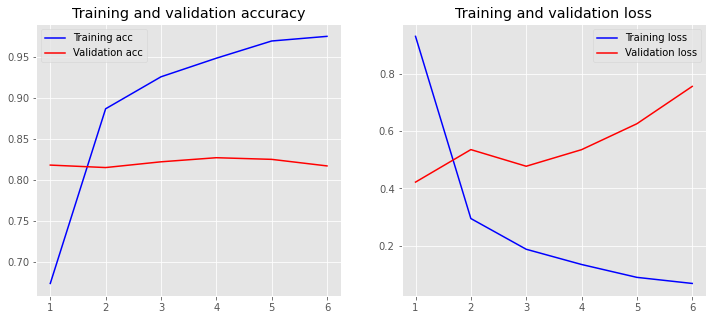

In [94]:
plot_history(history)

In [115]:
y_prob = model.predict(X_test[:32]) 
y_classes = y_prob.argmax(axis=-1)
print(y_classes)
print(y_test [:32].argmax(axis=-1))

[1 1 0 0 0 1 1 2 2 1 0 1 1 2 3 0 0 1 0 3 3 1 2 1 3 3 0 2 3 0 0 2]
[0 2 0 0 2 1 1 2 2 1 0 1 2 2 3 0 3 0 1 3 3 1 2 1 3 3 0 2 3 0 0 2]


In [110]:
import h5py

In [112]:
from tensorflow.keras.models import load_model

model.save('qa_model_rev3')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('qa_model_rev4')

In [113]:
model = load_model('qa_model_rev4')

In [104]:
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)


In [127]:
data = {}
#data['vectorized_data'] = test_vectorized_data
test_vectorized_data_serializable = []

for item in test_vectorized_data:
    test_vectorized_data_serializable.append(item.tolist())

data['vectorized_data'] = test_vectorized_data_serializable
data['form_data'] = test_form_data
data['correct'] = test_correct

with open(PATH_TO_SCIQ_DATASET + 'test-data-vectorized.txt', 'w') as outfile:
    json.dump(data, outfile)